#  adversarial training small model 


In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import os
from os.path import join


import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import gc


from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical
import copy

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report


from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [103]:
tf.config.run_functions_eagerly(False)

#### 1. Load Data

In [104]:
data=datasets.mnist.load_data(path='mnist.npz')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# X_train,y_train=data[0][0],data[0][1]
# X_test,y_test=data[1][0],data[1][1]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

""" Train """
X_train_img = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train):
    X_train_img[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
""" Test """
X_test_img = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test):
    X_test_img[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
X_train=X_train_img
X_test= X_test_img

LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

In [105]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

#### 2. Load model

In [106]:
small_model = tf.keras.models.Sequential()
small_model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(32,32,3)))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Conv2D(64, (3, 3), activation='relu'))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Flatten())
small_model.add(Dense(128, activation='relu'))
small_model.add(Dropout(0.3))
small_model.add(Dense(10, activation='softmax'))



small_model.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy']
    )




history = small_model.fit(X_train, y_train,
              epochs=10,
              batch_size = 128,
              validation_split=0.1,
              shuffle=True,
              verbose=1)



Epoch 1/10
422/422 [==============================] - 3s 8ms/step - loss: 0.8780 - accuracy: 0.7737 - val_loss: 0.3843 - val_accuracy: 0.8613
Epoch 2/10
422/422 [==============================] - 3s 7ms/step - loss: 0.3987 - accuracy: 0.8554 - val_loss: 0.3328 - val_accuracy: 0.8803
Epoch 3/10
422/422 [==============================] - 3s 7ms/step - loss: 0.3417 - accuracy: 0.8759 - val_loss: 0.2903 - val_accuracy: 0.8898
Epoch 4/10
422/422 [==============================] - 3s 7ms/step - loss: 0.3021 - accuracy: 0.8892 - val_loss: 0.2962 - val_accuracy: 0.8870
Epoch 5/10
422/422 [==============================] - 3s 7ms/step - loss: 0.2791 - accuracy: 0.8969 - val_loss: 0.2802 - val_accuracy: 0.8990
Epoch 6/10
422/422 [==============================] - 3s 7ms/step - loss: 0.2592 - accuracy: 0.9053 - val_loss: 0.2726 - val_accuracy: 0.9048
Epoch 7/10
422/422 [==============================] - 3s 7ms/step - loss: 0.2457 - accuracy: 0.9064 - val_loss: 0.2678 - val_accuracy: 0.9052
Epoch 

In [107]:
small_model.save_weights('/media/hdd1/benchmark_adversarial_attacks/small_model_weights.'+str(0)+'.hdf5')

#### 4. Load attacks 

Let's define the peformances metrics

In [108]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

#### Adversarial data set

adversarial_maker créer un lot d'exemple adverse mais correctement labelé puis les sauvegarde dans un fichier 


Cette fonction peut prendre beaucoup de temps ! 

In [109]:
def adversarial_maker(model,attack, image_list, labels,epsilon):
    model_to_fool = TensorFlowModel(model, bounds=(0, 255))
    success=[]
    adv_list=[]    
    adv_true_label=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        if bool(is_adv[0][0]) ==True:
            adv_list.append(np.array(clipped[0][0]))
            adv_true_label.append(labels[i])                
        
    return(adv_list,adv_true_label)


In [110]:
y_true=list(map(np.argmax,y_test))
attack_deepfool=LinfDeepFoolAttack()
attack_FGSM=LinfFastGradientAttack()
adv_list,adv_true_label=adversarial_maker(small_model,attack_deepfool, X_test[:5000], y_true[:5000],[10])

100%|██████████| 5000/5000 [27:47<00:00,  3.00it/s]  


Visualisation de quelques exemple du data set d'exemple adverse 

Nous avons 3643 exemples adverse qui ont générés à partir des 5000 premiers élement du test set. Ces exemples vont être coupés en deux sets.
Le premier adv_train_set (2643 exemples servira à l'entraienement adverse des modèles)
Le second adv_test_set (1000 exemples) servira à mesurer la performance d'un modèle face à des attaques adverses

In [111]:
len(adv_true_label)

2818

In [112]:
adv_train_set=np.array(adv_list[:1885])
adv_train_label=np.array(adv_true_label[:1885])
adv_test_set=np.array(adv_list[1885:])
adv_test_label=np.array(adv_true_label[1885:])


adv_train_label = to_categorical(adv_train_label, 10)
adv_test_label = to_categorical(adv_test_label, 10)

In [113]:
len(adv_test_set)

933

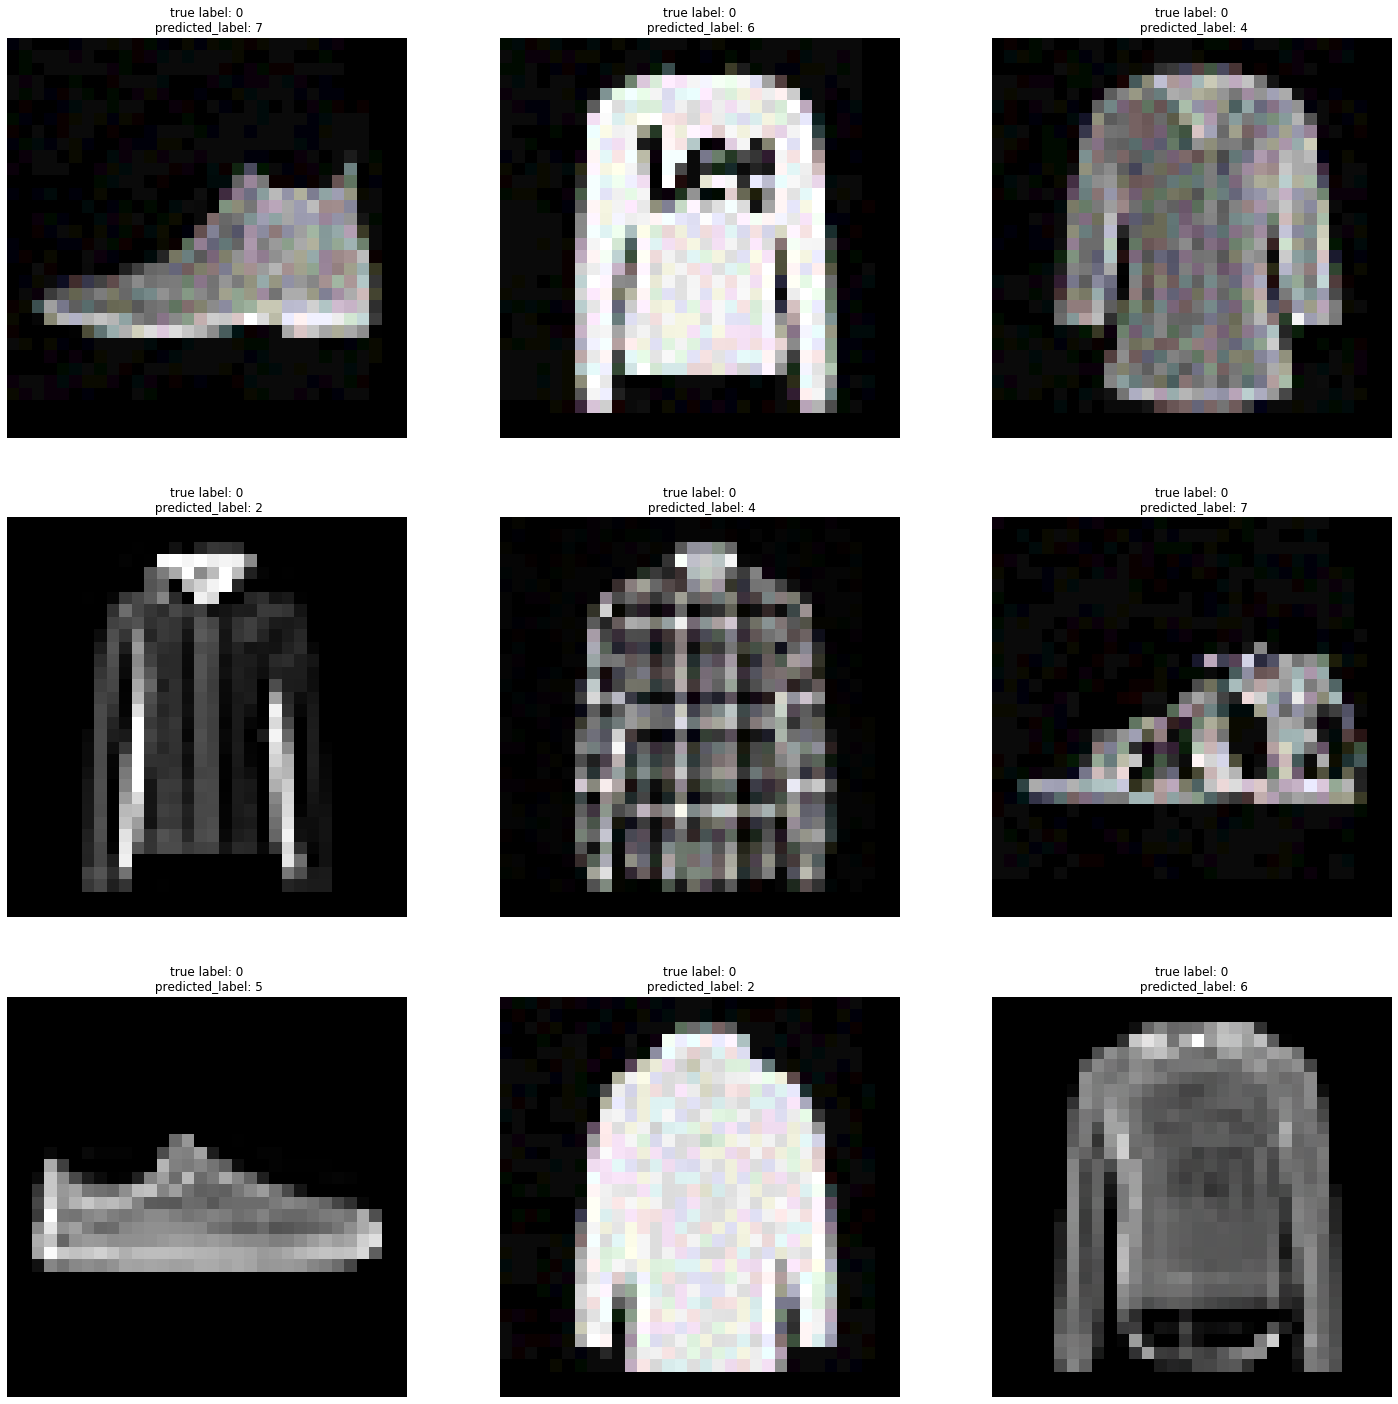

In [114]:
plt.figure(figsize=(25,25))
for i,(image, true_label) in enumerate(zip(adv_list[:9],adv_true_label[:9])): 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image/255)
    predicted_label=np.argmax(small_model.predict(np.expand_dims(image,axis=0)))
    true_label=np.argmax(true_label)
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_label))
    plt.axis("off")

ImageNet (déjà entrainé sur le train set) va être entrainé sur les exemples adverses. A chaque époque on eregistre une version du reseau, ce qui fait qu'on obtient 15 versions du réseaux plus ou moins familières avec les exemples adverses

In [115]:
model_checkpoint_callback= ModelCheckpoint(filepath='/media/hdd1/benchmark_adversarial_attacks/small_model_weights.{epoch:d}.hdf5', 
                          monitor='val_loss', 
                          verbose=1, 
                          save_best_only=False, 
                          save_weights_only=True, 
                          mode='auto', save_freq='epoch')

history=small_model.fit(adv_train_set,
                 adv_train_label,
                 epochs=15,
                 batch_size = 16,
                 shuffle=True,
                 verbose=1,
                 callbacks=[model_checkpoint_callback])

    
    

Epoch 1/15
117/118 [============================>.] - ETA: 0s - loss: 1.3454 - accuracy: 0.5235
Epoch 00001: saving model to /media/hdd1/benchmark_adversarial_attacks/small_model_weights.1.hdf5
118/118 [==============================] - 1s 6ms/step - loss: 1.3441 - accuracy: 0.5231
Epoch 2/15
112/118 [===========================>..] - ETA: 0s - loss: 0.9504 - accuracy: 0.6345
Epoch 00002: saving model to /media/hdd1/benchmark_adversarial_attacks/small_model_weights.2.hdf5
118/118 [==============================] - 1s 6ms/step - loss: 0.9496 - accuracy: 0.6313
Epoch 3/15
114/118 [===========================>..] - ETA: 0s - loss: 0.8201 - accuracy: 0.6771
Epoch 00003: saving model to /media/hdd1/benchmark_adversarial_attacks/small_model_weights.3.hdf5
118/118 [==============================] - 1s 6ms/step - loss: 0.8175 - accuracy: 0.6759
Epoch 4/15
111/118 [===========================>..] - ETA: 0s - loss: 0.7045 - accuracy: 0.7196
Epoch 00004: saving model to /media/hdd1/benchmark_adve

#### Test des modèles

In [116]:
model_accuracy={}
attack_success_rate={}



for val in tqdm(range(0,16)):       
    small_model.load_weights('/media/hdd1/benchmark_adversarial_attacks/small_model_weights.'+str(val)+'.hdf5')   
    y_adv_pred=list(map(np.argmax,small_model.predict(adv_test_set)))
    y_adv_true=list(map(np.argmax,adv_test_label))
    success_rate=np.sum([1 for i in range(len(y_adv_pred)) if y_adv_pred[i]!=y_adv_true[i]])/len(y_adv_pred)

    y_pred=list(map(np.argmax,small_model.predict(X_test[5000:])))
    y_true=list(map(np.argmax,y_test[5000:]))
    accuracy=np.sum([1 for i in range(len(y_pred)) if y_pred[i]==y_true[i]])/len(y_pred)               

    model_accuracy[val]=accuracy
    attack_success_rate[val]=success_rate

100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


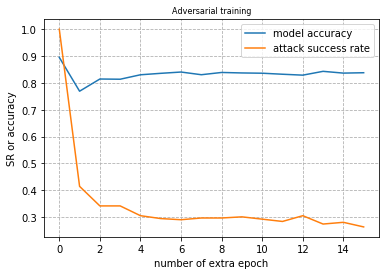

In [117]:
plt.plot(list(model_accuracy.keys()),list(model_accuracy.values()),label='model accuracy')
plt.plot(list(attack_success_rate.keys()),list(attack_success_rate.values()),label='attack success rate')
plt.grid(True,which="both", linestyle='--')
plt.title('Adversarial training', fontsize=8)
plt.xlabel('number of extra epoch')
plt.ylabel('SR or accuracy')
plt.legend(loc='upper right')
plt.show()

### Attaques 'from scratch'

In [118]:
def attack_performances_computer(model_to_fool,attack, image_list, labels,epsilon):
    model_to_fool = TensorFlowModel(model_to_fool, bounds=(0, 255))
    success=[]
    adv_list=[]
    attack_value=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        success.append(bool(is_adv[0][0]))
        adv_list.append(np.array(clipped[0][0]))
        prediction=small_model.predict(np.expand_dims(clipped[0][0],axis=0))           
        attack_value+=[np.argmax(prediction)]
    DOC_attack=DOC(adv_list,image_list)
    SR_attack=succes_rate(success)
    return(SR_attack)

y_true=list(map(np.argmax,y_test))

In [119]:
attack_from_scratch_success_rate={}
attack_FGSM=LinfFastGradientAttack()
y_true=list(map(np.argmax,y_test))


for val in tqdm(range(1,16)):       
    small_model.load_weights('/media/hdd1/benchmark_adversarial_attacks/small_model_weights.'+str(val)+'.hdf5')   
    SR=attack_performances_computer(small_model,attack_FGSM, X_test[5000:6000], y_true[5000:6000],[0.01])
    attack_from_scratch_success_rate[val]=SR
   

100%|██████████| 15/15 [08:27<00:00, 33.82s/it]


In [120]:
# with open('data/attack_from_scratch', 'wb') as f:
#     pickle.Pickler(f).dump(attack_from_scratch_success_rate)


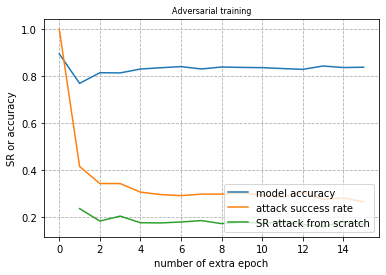

In [121]:
plt.plot(list(model_accuracy.keys()),list(model_accuracy.values()),label='model accuracy')
plt.plot(list(attack_success_rate.keys()),list(attack_success_rate.values()),label='attack success rate')
plt.plot(list(attack_from_scratch_success_rate.keys()),list(attack_from_scratch_success_rate.values()),label='SR attack from scratch')
plt.grid(True,which="both", linestyle='--')
plt.title('Adversarial training', fontsize=8)
plt.xlabel('number of extra epoch')
plt.ylabel('SR or accuracy')
plt.legend(loc='lower right')
plt.show()